# Agent Learning Project

## Imports 

We start by importing the required libaries. Uncomment & run the next cell in case some of the libraries aren't installed in your environment. 

In [1]:
# !pip install numpy matplotlib

In [2]:
import numpy as np # Useful for computations and probabilistic distributions
import matplotlib.pyplot as plt # Plotting Graph for Simulation results
import statistics # Useful to get statistics at the end of the Simulation
import tkinter as tk # Graphical Interface library 
from collections import defaultdict # Specific kind of dictionary that avoids KeyErrors

## Defining the Agent class

We define a type of agent with the following attributes: 
- Agent name : Name of the agent
- Service probability : If at the counter, shows the probability that this agent will be serviced.
- Reward : Reward the counter gets for servicing this agent
- Time in queue : Time for which the agent has been in the queue. 

In [3]:
class Agent:
    def __init__(self, agent_name):
        self.agent_name = agent_name
        self.service_prob = agents[agent_name][0]
        self.reward = agents[agent_name][1]
        self.time_in_queue = 0

    def __str__(self):
        return f"Agent {self.agent_name} ({self.time_in_queue})"

## Defining the Queue mechanism 

In [4]:
class QueueSimulation:
    def __init__(self, agents, arrival_prob, strategy, start=4, alpha=0):
        self.agents = agents
        self.arrival_prob = arrival_prob
        self.agent_distribution = [list(agents.values())[i][2] for i in range(len(list(agents.values())))]
        self.strategy = strategy
        self.start = start
        self.alpha = alpha
        self.queue = [self.create_agent() for _ in range(start)]
        self.current_agent = None
        self.time = 0
        self.total_reward = 0
        self.serviced_agents = defaultdict(int)
        self.reward_history = []
        self.queue_length_history = []

    def create_agent(self):
        agent_name = np.random.choice(list(self.agents.keys()), p=self.agent_distribution)
        return Agent(agent_name)

    def step(self):
        # Check if the current agent is done being served
        if self.current_agent:
            if np.random.rand() < self.current_agent.service_prob:
                self.total_reward += self.current_agent.reward
                self.serviced_agents[self.current_agent.agent_name] += 1
                self.current_agent = None

        # Increment time_in_queue for all agents in the queue
        for agent in self.queue:
            agent.time_in_queue += 1

        # Add new agent to the queue based on arrival probability
        if np.random.rand() < self.arrival_prob:
            new_agent = self.create_agent()
            self.queue.append(new_agent)

        self.time += 1

        # Add a penalty which is proportional to the queue length
        self.total_reward += penalty(self.alpha,len(self.queue))

        # Apply the strategy to select the next agent
        if self.queue:
            queue_index = self.strategy(self.queue,self.current_agent)
            self.swap_agents(queue_index)

        # Record history
        self.reward_history.append(self.total_reward)
        self.queue_length_history.append(len(self.queue))

    def get_queue_status(self):
        return [str(agent) for agent in self.queue]

    def get_current_agent(self):
        return str(self.current_agent) if self.current_agent else "None"

    def get_total_reward(self):
        return self.total_reward

    def swap_agents(self, queue_index):
        if 0 <= queue_index < len(self.queue):
            if self.current_agent:
                self.queue[queue_index], self.current_agent = (self.current_agent,self.queue[queue_index])
            else:
                self.current_agent = self.queue.pop(queue_index)

    def run_simulation(self, steps=1000):
        for _ in range(steps):
            self.step()

    def plot_results(self):
        # Plot total reward over time
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.reward_history)
        plt.title('Total Reward over Time')
        plt.xlabel('Time')
        plt.ylabel('Total Reward')

        # Plot queue length over time
        plt.subplot(1, 3, 2)
        plt.plot(self.queue_length_history)
        plt.title('Queue Length over Time')
        plt.xlabel('Time')
        plt.ylabel('Queue Length')

        # Plot distribution of serviced agents by type
        plt.subplot(1, 3, 3)
        agent_types, counts = zip(*sorted(self.serviced_agents.items()))
        plt.bar(agent_types, counts)
        plt.title('Distribution of Serviced Agents by Type')
        plt.xlabel('Agent Type')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()


## Designing our Graphical User Interface

In [5]:
class QueueSimulationGUI:
    def __init__(self, master, simulation):
        self.master = master
        self.simulation = simulation
        self.master.title("Queue Simulation")

        # Frame for displaying the time
        self.time_frame = tk.Frame(master)
        self.time_frame.pack(pady=10)

        self.time_label = tk.Label(
            self.time_frame, text="Time: 0", font=("Helvetica", 14)
        )
        self.time_label.pack()

        # Frame for displaying the queue with scrollable canvas
        self.queue_frame = tk.Frame(master)
        self.queue_frame.pack(pady=10, fill=tk.BOTH, expand=True)

        self.queue_label = tk.Label(
            self.queue_frame,
            text=f"Queue - Length: {len(self.simulation.queue)}",
            font=("Helvetica", 14),
        )
        self.queue_label.pack()

        self.queue_canvas = tk.Canvas(
            self.queue_frame, width=600, height=150, bg="white"
        )
        self.queue_canvas.pack(side=tk.TOP, fill=tk.BOTH, expand=True) 

        self.scrollbar = tk.Scrollbar(self.queue_frame, orient=tk.HORIZONTAL, command=self.queue_canvas.xview)
        self.scrollbar.pack(side=tk.TOP, fill=tk.X)  # Change from BOTTOM to TOP
        
        self.queue_canvas.config(xscrollcommand=self.scrollbar.set)

        self.inner_queue_frame = tk.Frame(self.queue_canvas)
        self.queue_canvas.create_window((0, 0), window=self.inner_queue_frame, anchor='nw')

        # Frame for displaying the current agent at the counter
        self.counter_frame = tk.Frame(master)
        self.counter_frame.pack(pady=10)

        self.counter_label = tk.Label(
            self.counter_frame, text="Counter", font=("Helvetica", 14)
        )
        self.counter_label.pack()

        self.counter_canvas = tk.Canvas(
            self.counter_frame, width=200, height=100, bg="white"
        )
        self.counter_canvas.pack()

        # Frame for displaying the total reward
        self.reward_frame = tk.Frame(master)
        self.reward_frame.pack(pady=10)

        self.reward_label = tk.Label(
            self.reward_frame, text="Total Reward: 0", font=("Helvetica", 14)
        )
        self.reward_label.pack()

        # Frame for action buttons
        self.action_frame = tk.Frame(master)
        self.action_frame.pack(pady=10)

        self.next_step_button = tk.Button(
            self.action_frame, text="Next Step", command=self.next_step
        )
        self.next_step_button.pack(side=tk.LEFT, padx=10)

        self.reset_button = tk.Button(
            self.action_frame, text="Reset", command=self.reset_simulation
        )
        self.reset_button.pack(side=tk.LEFT, padx=10)

        # Frame for input and switch button
        self.input_frame = tk.Frame(master)
        self.input_frame.pack(pady=10)

        self.index_label = tk.Label(
            self.input_frame, text="Enter Queue Index:", font=("Helvetica", 14)
        )
        self.index_label.pack(side=tk.LEFT)

        self.index_entry = tk.Entry(self.input_frame, width=5)
        self.index_entry.pack(side=tk.LEFT, padx=5)

        self.switch_button = tk.Button(
            self.input_frame, text="Switch", command=self.switch_agent
        )
        self.switch_button.pack(side=tk.LEFT, padx=10)

        self.reset_simulation()

    def next_step(self):
        self.simulation.step()
        self.update_labels()

    def switch_agent(self):
        try:
            agent_index = int(self.index_entry.get())
            self.simulation.swap_agents(agent_index)
            self.update_labels()
        except Exception:
            pass  # We could imagine adding an error message here

    def update_labels(self):
        self.time_label.config(text=f"Time: {self.simulation.time}")
        self.reward_label.config(
            text=f"Total Reward: {self.simulation.get_total_reward()}"
        )
        self.queue_label.config(
            text=f"Queue - Length: {len(self.simulation.queue)}",
        )

        # Update queue visualization
        self.queue_canvas.delete("all")
        box_width = 150
        for idx, agent in enumerate(self.simulation.queue):
            self.queue_canvas.create_rectangle(
                10 + box_width * idx, 10, box_width + box_width * idx, 60, fill="lightblue"
            )
            self.queue_canvas.create_text(10 + box_width * idx + box_width / 2, 35, text=str(agent))

        self.queue_canvas.config(scrollregion=self.queue_canvas.bbox("all"))

        # Update counter visualization
        self.counter_canvas.delete("all")
        if self.simulation.current_agent:
            self.counter_canvas.create_rectangle(50, 10, 150, 60, fill="lightgreen")
            self.counter_canvas.create_text(
                100, 35, text=str(self.simulation.current_agent.agent_name)
            )
        else:
            self.counter_canvas.create_text(100, 35, text="Empty")

    def reset_simulation(self):
        self.simulation = QueueSimulation(
            self.simulation.agents,
            self.simulation.arrival_prob,
            self.simulation.strategy,
            start=self.simulation.start,
            alpha=self.simulation.alpha,
        )
        self.update_labels()


## Defining strategies

In [6]:
def priority_list_strategy(queue, current_agent, priority_list):
    if current_agent and priority_list.index(current_agent.agent_name) == 0:
        return -1
    return min(range(len(queue)), key=lambda i: priority_list.index(queue[i].agent_name))

def random_selection(queue, current_agent):
    return np.random.randint(-1, len(queue) + 1)

def first_in_first_served(queue, current_agent):
    if current_agent:
        return -1
    return 0

def dynamic_strategy(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: current_agent.time_in_queue if i == -1 else queue[i].time_in_queue)
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue)

def shortest_service_time_first(queue, current_agent):
    if current_agent:
        return min(range(-1, len(queue)), key=lambda i: current_agent.service_prob if i == -1 else queue[i].service_prob)
    return min(range(len(queue)), key=lambda i: queue[i].service_prob)

def highest_reward_first(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: current_agent.reward if i == -1 else queue[i].reward)
    return max(range(len(queue)), key=lambda i: queue[i].reward)

def longest_queue_time_reward(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: (current_agent.time_in_queue * current_agent.reward) if i == -1 else (queue[i].time_in_queue * queue[i].reward))
    return max(range(len(queue)), key=lambda i: (queue[i].time_in_queue * queue[i].reward))

def least_reward_per_service_time(queue, current_agent):
    if current_agent:
        return min(range(-1, len(queue)), key=lambda i: (current_agent.reward / current_agent.service_prob) if i == -1 else (queue[i].reward / queue[i].service_prob))
    return min(range(len(queue)), key=lambda i: queue[i].reward / queue[i].service_prob)

def dynamic_priority_adjustment(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: (current_agent.time_in_queue + current_agent.reward) if i == -1 else (queue[i].time_in_queue + queue[i].reward))
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue + queue[i].reward)

def highest_reward_per_waiting_time(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: (current_agent.reward / (current_agent.time_in_queue + 1)) if i == -1 else (queue[i].reward / (queue[i].time_in_queue + 1)))
    return max(range(len(queue)), key=lambda i: queue[i].reward / (queue[i].time_in_queue + 1))

def longest_waiting_with_penalty(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: (current_agent.time_in_queue - 0.1 * current_agent.reward) if i == -1 else (queue[i].time_in_queue - 0.1 * queue[i].reward))
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue - 0.1 * queue[i].reward)

def reward_service_prob_adjustment(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: (current_agent.reward * current_agent.service_prob) if i == -1 else (queue[i].reward * queue[i].service_prob))
    return max(range(len(queue)), key=lambda i: queue[i].reward * queue[i].service_prob)

def weighted_random_selection(queue, current_agent):
    if current_agent:
        weights = [current_agent.time_in_queue + current_agent.reward] + [agent.time_in_queue + agent.reward for agent in queue]
    else:
        weights = [agent.time_in_queue + agent.reward for agent in queue]
    total_weight = sum(weights)
    probabilities = [weight / total_weight for weight in weights]
    return np.random.choice(range(-1, len(queue)), p=probabilities)

def combined_priority_waiting(queue, current_agent, priority_list):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: (current_agent.time_in_queue * priority_list.index(current_agent.agent_name)) if i == -1 else (queue[i].time_in_queue * priority_list.index(queue[i].agent_name)))
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue * priority_list.index(queue[i].agent_name))


### Explanations of strategies

- **priority_list_strategy**: Selects agents based on a predefined priority list.
- **first_in_first_served**: Selects the first agent in the queue.
- **dynamic_strategy**: Selects the agent who has been waiting the longest.
- **shortest_service_time_first**: Selects the agent with the shortest service time.
- **highest_reward_first**: Selects the agent with the highest reward.
- **longest_queue_time_reward**: Selects the agent with the longest wait time multiplied by reward.
- **random_selection**: Selects an agent randomly from the queue.
- **least_reward_per_service_time**: Selects the agent with the least reward per unit of service time.
- **dynamic_priority_adjustment**: Selects the agent with the highest combined value of waiting time and reward.
- **highest_reward_per_waiting_time**: Selects the agent with the highest reward per unit of waiting time.
- **longest_waiting_with_penalty**: Selects the agent with the longest wait time, penalizing high rewards.
- **reward_service_prob_adjustment**: Selects the agent with the highest product of reward and service probability.
- **weighted_random_selection**: Selects an agent based on weighted probabilities of their waiting time and reward.
- **combined_priority_waiting**: Selects the agent based on a combination of priority list and waiting time.

The next step could be to implement more complex dynamic strategies and Machine Learning based strategies.

## Choosing base parameters

In [7]:
# Defining Agents
agents = {
    "Alex" : [0.7, 10, 0.3], # Agent name : [service_probability, reward, agent_distribution]
    "Ben" : [0.5, 20, 0.15],
    "Cameron" : [0.3, 30, 0.2],
    "Dennis" : [0.4, 20, 0.1],
    "Eric": [0.8, 4, 0.2],
    "Fabien": [0.5, 50, 0.05],
}
# Probabilty that a new agent joins the queue
arrival_prob = 0.51

# Number of agents in the queue at t = 0
start = 5

# Penalty coefficient and function for the length of the queue
alpha = 0.05
def penalty(alpha,length):
    return -alpha*length

# Choosing the strategy (full list of strategies above)
priority_list = ["Eric","Ben", "Alex", "Fabien", "Cameron", "Dennis"]
strategy = lambda queue, current_agent: priority_list_strategy(queue, current_agent, priority_list)

## Playing the game manually

Execute the main code manually and play the game by making your own decisions through the graphical user interface.

In [8]:
should_run = False # Change should_run if you want to play manually
if should_run:
    strategy = first_in_first_served
    simulation = QueueSimulation(agents, arrival_prob, strategy, start, alpha=alpha)
    root = tk.Tk()
    gui = QueueSimulationGUI(root, simulation)
    root.mainloop()

## Playing the game according to predetermined strategies

Execute the main code automatically by choosing one of the strategies defined above in the 'Define Strategies' section and letting the computer play by itself. This function outputs three graphs. 
- Graph 1: Total reward from time $t_0$ to time $t_{1000}$.
- Graph 2: Length of the Queue from time $t_0$ to time $t_{1000}$.
- Graph 3: Distribution of serviced Agents by type from $t_0$ to time $t_{1000}$.



### Running a specific strategy

Automatic simulation with strategy '<lambda>'


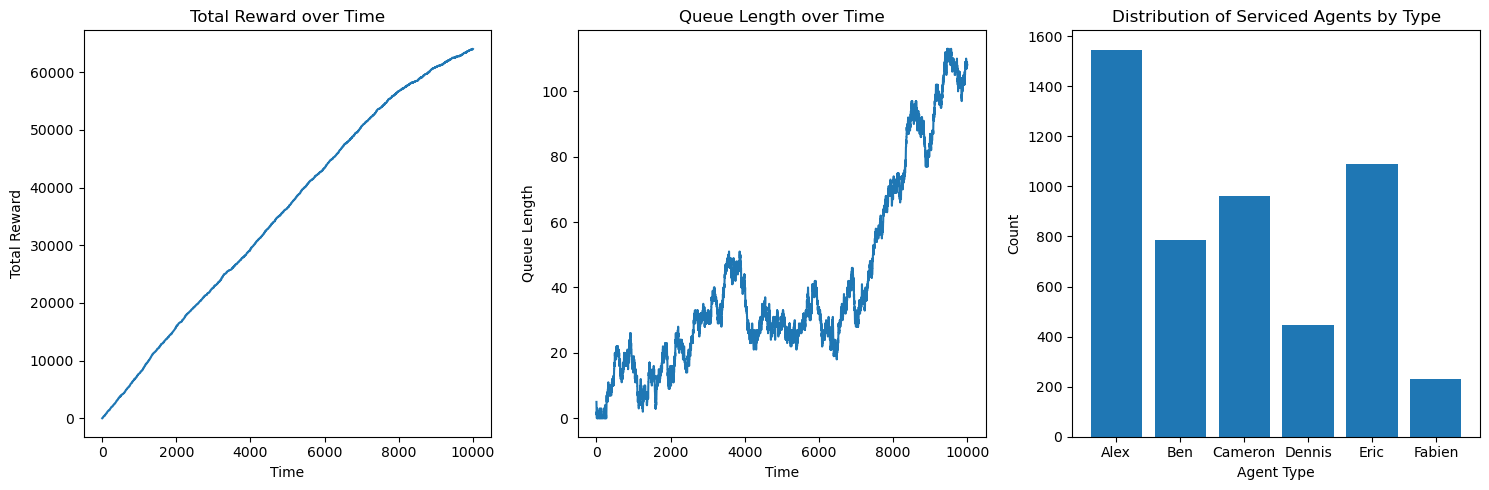

In [9]:
simulation = QueueSimulation(
    agents,
    arrival_prob,
    strategy,
    start,
    alpha,
)

print(f"Automatic simulation with strategy '{strategy.__name__}'")
simulation.run_simulation(steps=10000)
simulation.plot_results()

### Comparing strategies

Automatic simulation with strategy '<lambda>'


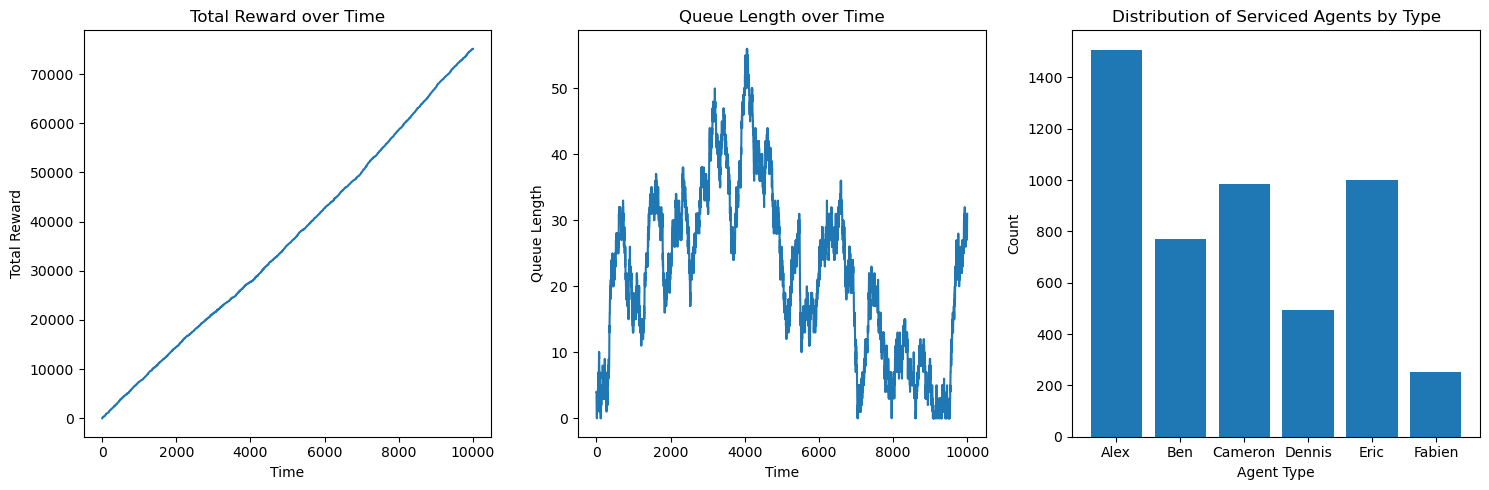

Automatic simulation with strategy 'first_in_first_served'


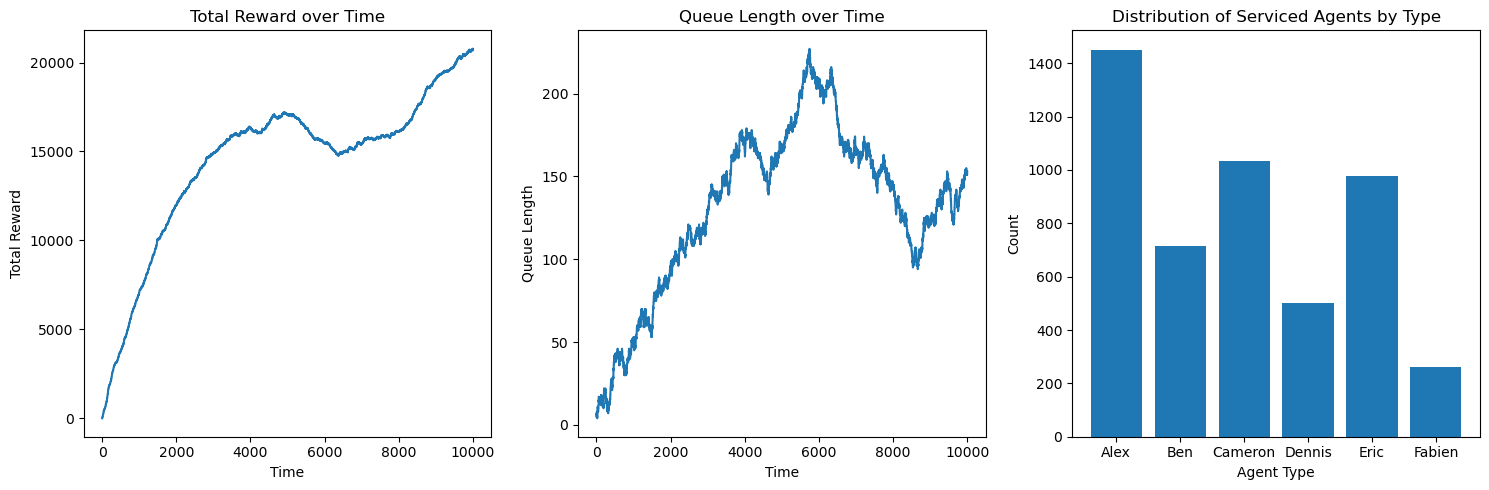

Automatic simulation with strategy 'dynamic_strategy'


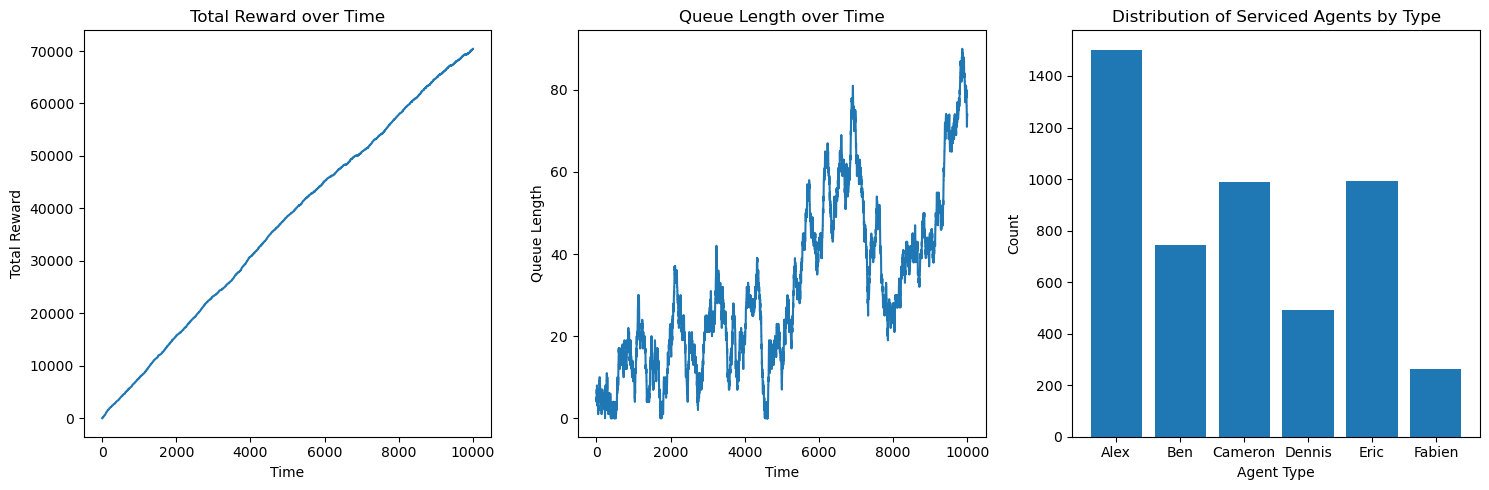

Automatic simulation with strategy 'shortest_service_time_first'


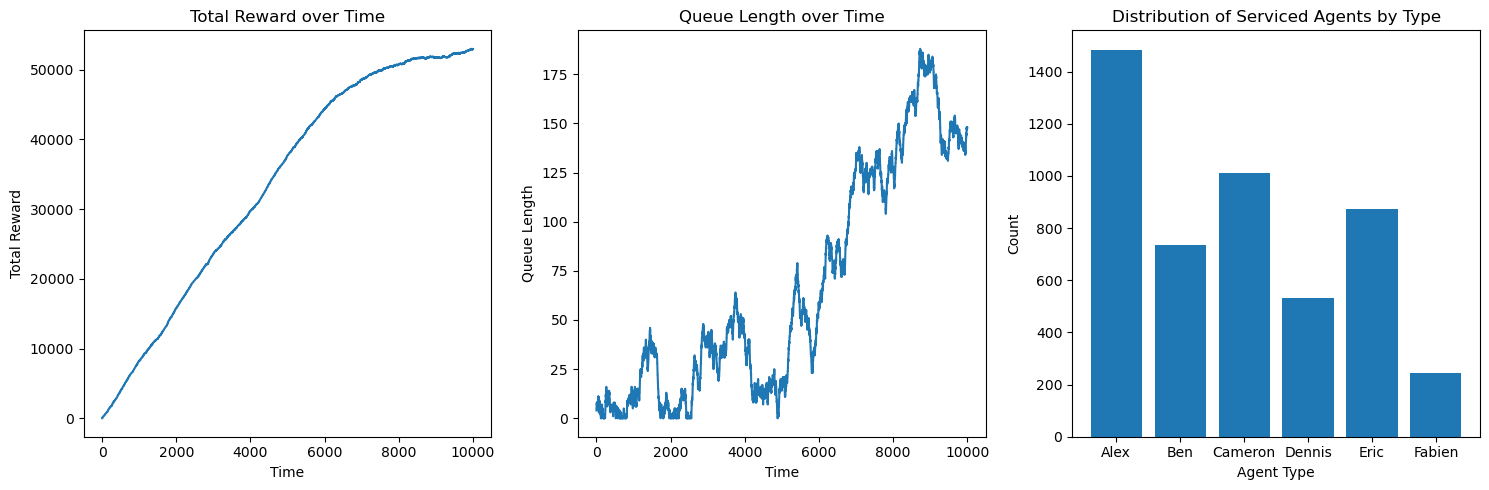

Automatic simulation with strategy 'highest_reward_first'


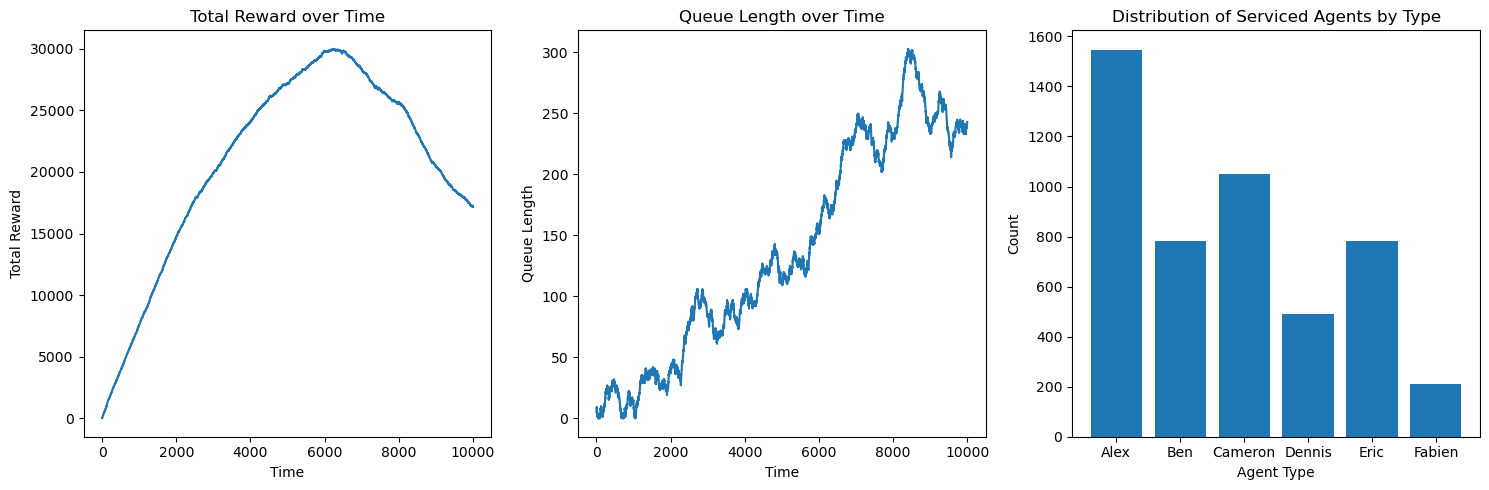

Automatic simulation with strategy 'random_selection'


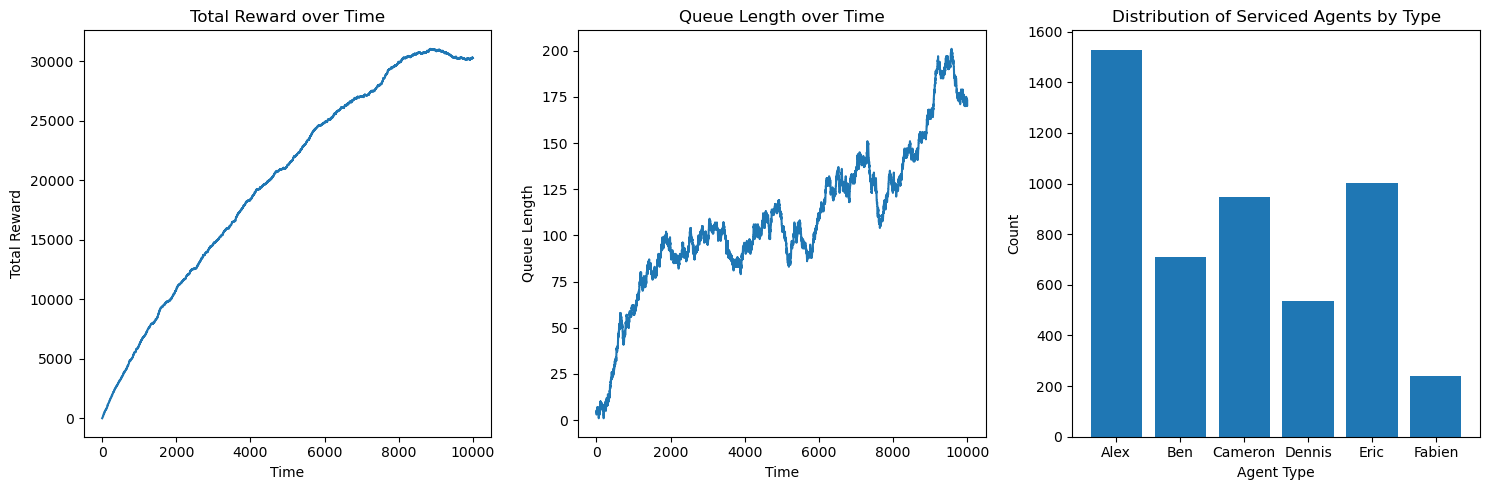

Automatic simulation with strategy 'highest_reward_per_waiting_time'


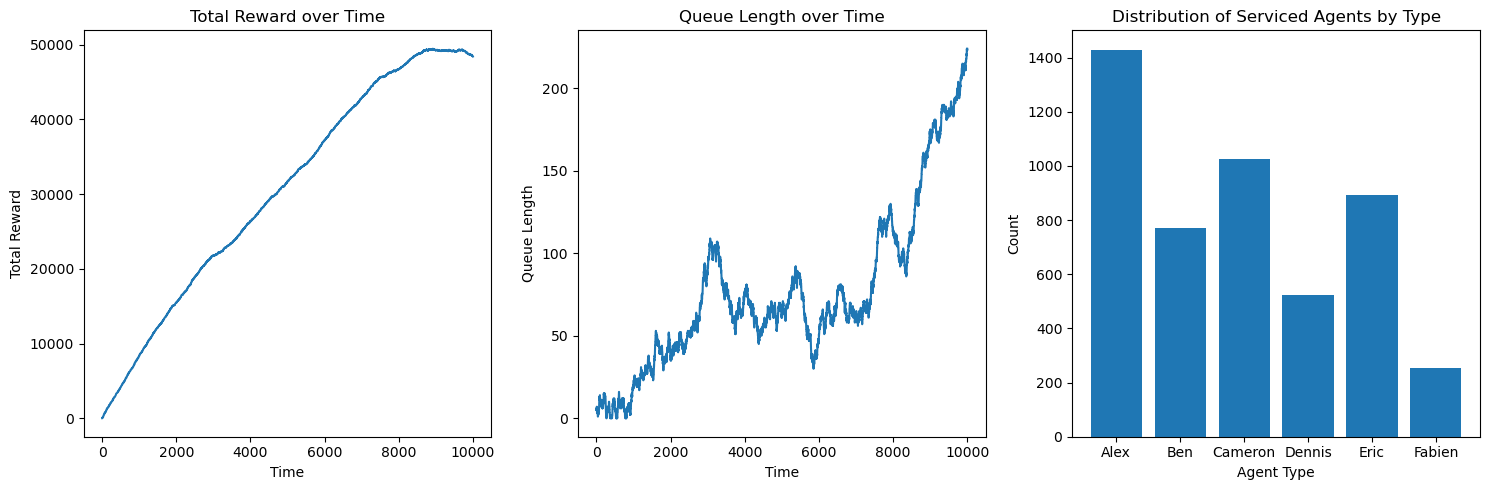

In [10]:
# Initialize a dictionary to store the results
results = {}

for strategy in [1, 
          first_in_first_served, 
          dynamic_strategy, 
          shortest_service_time_first, 
          highest_reward_first, 
          random_selection,  
          highest_reward_per_waiting_time,
         ]: # Write the strategies you want to compare with special cases if you need to add some arguments
    if strategy == 1:
        priority_list = ["Eric","Ben", "Alex", "Fabien", "Cameron", "Dennis"]
        strategy = lambda queue, current_agent: priority_list_strategy(queue, current_agent, priority_list)

    
    simulation = QueueSimulation(agents, arrival_prob, strategy, start, alpha)

    print(f"Automatic simulation with strategy '{strategy.__name__}'")
    simulation.run_simulation(steps=10000)
    simulation.plot_results()
    
    queue_lengths = simulation.queue_length_history
    total_reward = simulation.get_total_reward()
    agent_distribution = simulation.serviced_agents
    
    results[strategy.__name__] = {
        "total_reward": total_reward,
        "min_queue_length": np.min(queue_lengths),
        "max_queue_length": np.max(queue_lengths),
        "mean_queue_length": np.mean(queue_lengths),
        "median_queue_length": np.median(queue_lengths),
        "mode_queue_length": statistics.mode(queue_lengths),
        "normalized_distribution": {agent_type: round(count / sum(agent_distribution.values()), 3) for agent_type, count in sorted(agent_distribution.items(),key=lambda item: item[1],reverse=True)}
    }

### Statistics

In [11]:
# Find the strategy with the most reward
best_strategy = max(results.items(), key=lambda x: x[1]["total_reward"])


# Print the results
print(f"\nBest Strategy: {best_strategy[0]} with total reward of r = {best_strategy[1]['total_reward']}")
print(f"Min & Max Queue Length: {best_strategy[1]['min_queue_length']} & {best_strategy[1]['max_queue_length']}")
print(f"Mean & Median Queue Length: {best_strategy[1]['mean_queue_length']} & {best_strategy[1]['median_queue_length']}")
print(f"Mode Queue Length: {best_strategy[1]['mode_queue_length']}")
print(f"Normalized Distribution of Serviced Agents: {best_strategy[1]['normalized_distribution']}")


Best Strategy: <lambda> with total reward of r = 75145.59999999925
Min & Max Queue Length: 0 & 56
Mean & Median Queue Length: 22.188 & 23.0
Mode Queue Length: 29
Normalized Distribution of Serviced Agents: {'Alex': 0.301, 'Eric': 0.2, 'Cameron': 0.197, 'Ben': 0.154, 'Dennis': 0.098, 'Fabien': 0.051}


# Comments

In case something needs to be changed, please feel free to write something in the cell below and email me about it. 

*blank*